Objective: This notebook aims to explore and compare different models for predicting the number of monthly collisions.

- Moving Average (MA) Model: This model applies a simple smoothing technique by averaging a fixed window of past values to forecast future data points.

- ARIMA Model: ARIMA integrates three components: autoregression (AR), differencing (I), and moving averages (MA) to make predictions. Here use the auto_arima function to automatically determine the optimal parameters for the model.

- Prophet Model: Designed for time series data with strong seasonality, the Prophet model can handle missing data and outliers, making it suitable for capturing monthly, weekly, and yearly trends.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [2]:
df = pd.read_csv("crashes_data.csv")
df.head()

,year,month,crashes
0,2009.0,1.0,"8,868"
1,2009.0,2.0,"7,057"
2,2009.0,3.0,"8,142"
3,2009.0,4.0,"7,729"
4,2009.0,5.0,"8,668"


In [3]:
df.dtypes

year       float64
month      float64
crashes     object
dtype: object

In [4]:
# Combine year and month columns and format as yyyy-mm
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1)).dt.strftime('%Y-%m')
df = df[['date', 'crashes']]
df.head()

,date,crashes
0,2009-01,"8,868"
1,2009-02,"7,057"
2,2009-03,"8,142"
3,2009-04,"7,729"
4,2009-05,"8,668"


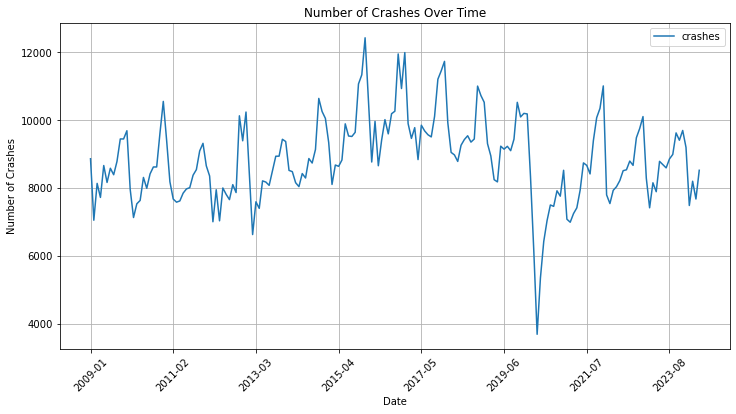

In [5]:
# Convert 'crashes' column to numeric, removing any commas
df['crashes'] = df['crashes'].str.replace(',', '').astype(float)

# Plot the data
df.plot(x='date', y='crashes', kind='line', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.title('Number of Crashes Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Decomposition

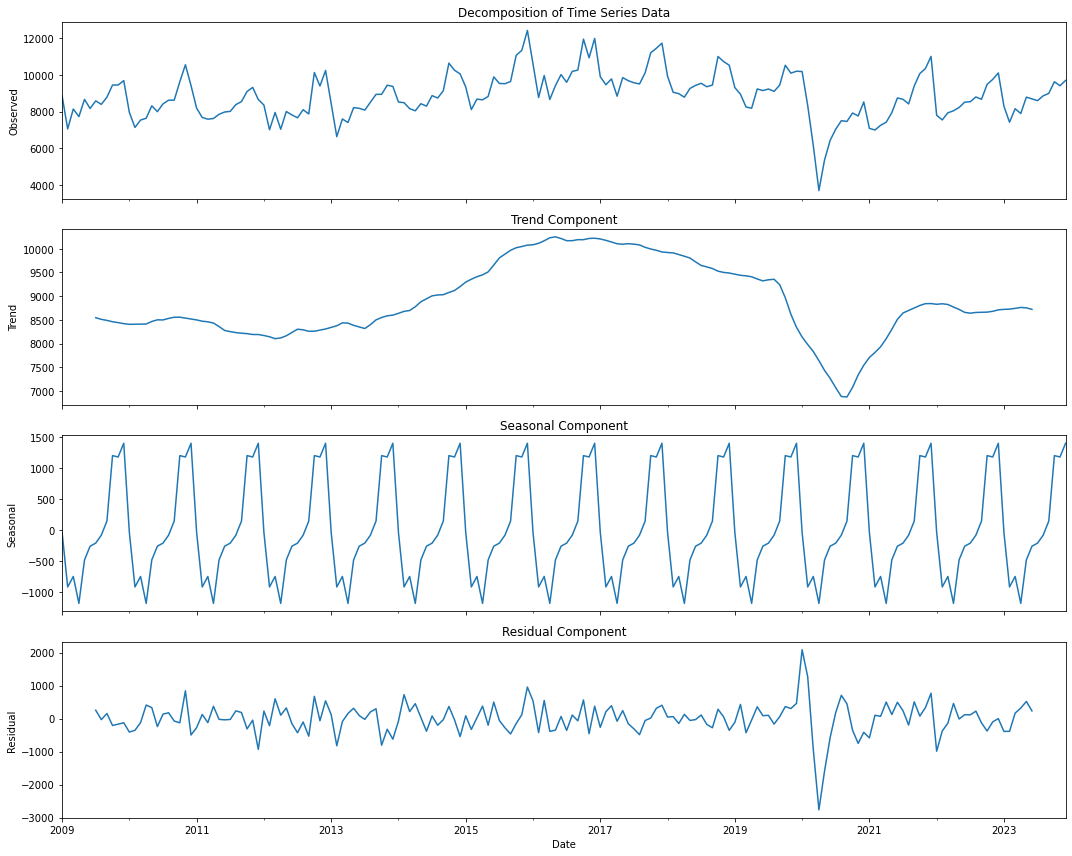

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Fill or interpolate missing values
df['crashes'] = df['crashes'].interpolate(method='linear')  # You can also use ffill/bfill if preferred

# Optional: Truncate data to the full years (2019-2023)
df = df[df.index < '2024-01-01']  # Only keep data before 2024

# Decompose the time series (period set to 12 for monthly data)
decomposition = seasonal_decompose(df['crashes'], model='additive', period=12)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Decomposition of Time Series Data')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend Component')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal Component')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()

### ACF & PACF

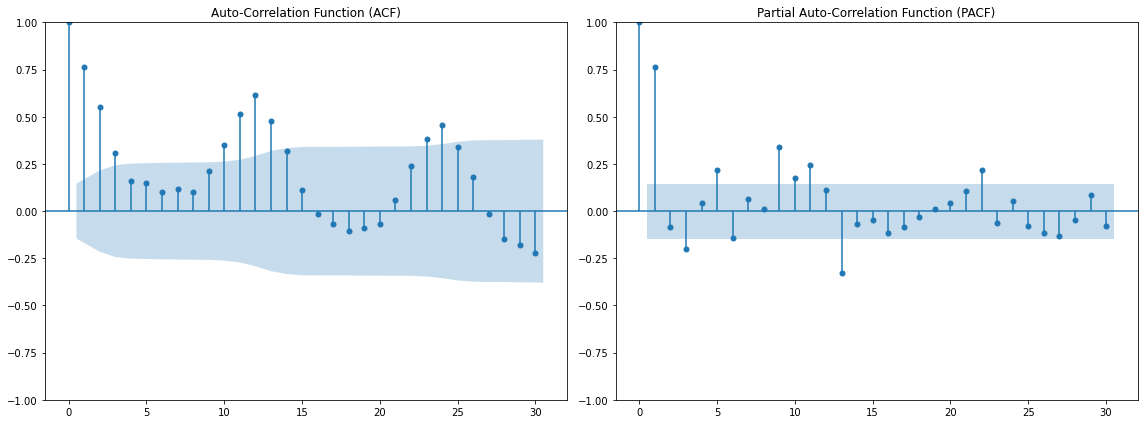

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF on the first subplot
plot_acf(df['crashes'], lags=30, ax=axes[0])  # Adjust lags as needed
axes[0].set_title('Auto-Correlation Function (ACF)')

# Plot PACF on the second subplot
plot_pacf(df['crashes'], lags=30, ax=axes[1])  # Adjust lags as needed
axes[1].set_title('Partial Auto-Correlation Function (PACF)')

# Adjust layout
plt.tight_layout()
plt.show()

### Forecasting

#### MA Model

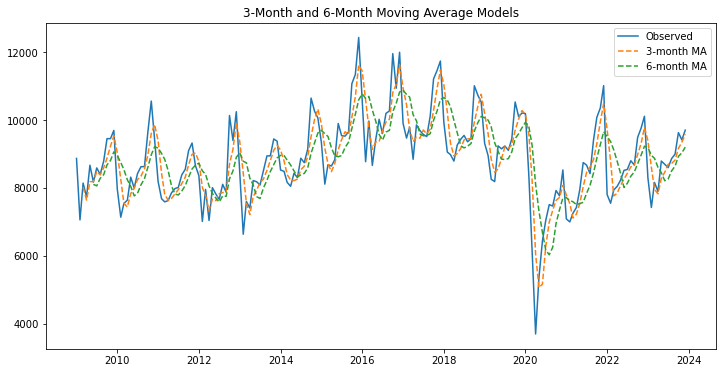

In [9]:
# 3-month Moving Average
df.loc[:, '3_month_MA'] = df['crashes'].rolling(window=3).mean()

# 6-month Moving Average
df.loc[:, '6_month_MA'] = df['crashes'].rolling(window=6).mean()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['crashes'], label='Observed')
plt.plot(df['3_month_MA'], label='3-month MA', linestyle='--')
plt.plot(df['6_month_MA'], label='6-month MA', linestyle='--')
plt.legend(loc='best')
plt.title('3-Month and 6-Month Moving Average Models')
plt.show()


#### ARIMA Model

In [10]:
# Filter the data for 2019-2022 for training and the last 12 months for testing
train_data = df.loc['2009':'2022'][['crashes']]
test_data = df.loc['2023':'2024'][['crashes']]  # assuming the last 12 months are from 2023 onward

# Check the data split
print(f"Train data: {train_data.shape}, Test data: {test_data.shape}")

Train data: (168, 1), Test data: (12, 1)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2753.408, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3536.994, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3326.801, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2755.145, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2753.834, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2756.376, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2730.594, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2784.588, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2729.252, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2878.678, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2730.137, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2733.1

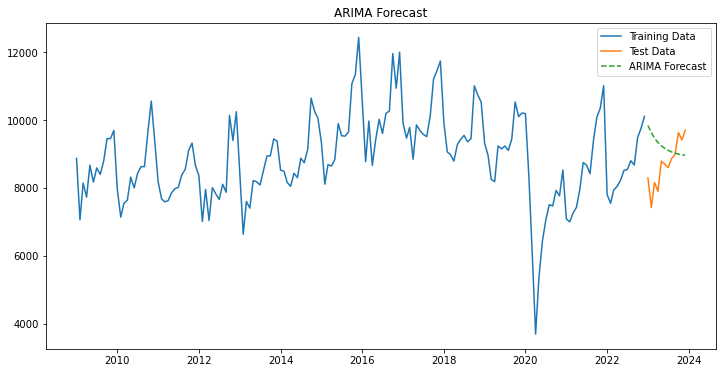

MSE (ARIMA): 1072211.4808437075


In [11]:
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Auto ARIMA model for the training data
model_arima = pm.auto_arima(train_data, start_p=1, start_q=1, max_p=5, max_q=5, seasonal=False, trace=True)

# Fit the model
model_arima.fit(train_data)

# Predict the next 12 periods (the test period)
forecast_arima = model_arima.predict(n_periods=len(test_data))

# Plot ARIMA forecast vs test data
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

# Calculate MSE for ARIMA
mse_arima = mean_squared_error(test_data, forecast_arima)
print(f'MSE (ARIMA): {mse_arima}')

#### Prophet Model

11:35:38 - cmdstanpy - INFO - Chain [1] start processing
11:35:38 - cmdstanpy - INFO - Chain [1] done processing


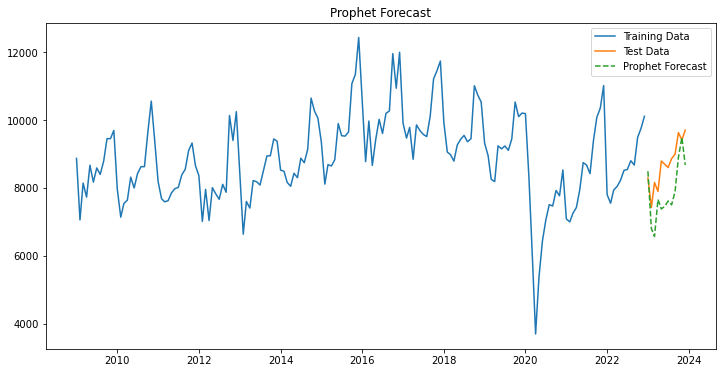

MSE (Prophet): 1013766.0431832272


In [37]:
from prophet import Prophet

# Prepare the data for Prophet
df_prophet_train = train_data.reset_index()[['date', 'crashes']].rename(columns={'date': 'ds', 'crashes': 'y'})
df_prophet_test = test_data.reset_index()[['date', 'crashes']].rename(columns={'date': 'ds', 'crashes': 'y'})

# Instantiate and fit the Prophet model
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=False)
model_prophet.fit(df_prophet_train)

# Create future dataframe for the test period
future = model_prophet.make_future_dataframe(periods=len(test_data), freq='ME')

# Make forecast
forecast_prophet = model_prophet.predict(future)

# Plot Prophet forecast vs test data
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(np.array(test_data.index), forecast_prophet['yhat'][-len(test_data):].values, label='Prophet Forecast', linestyle='--')
plt.legend(loc='best')
plt.title('Prophet Forecast')
plt.show()

# Calculate MSE for Prophet
mse_prophet = mean_squared_error(test_data, forecast_prophet['yhat'][-len(test_data):])
print(f'MSE (Prophet): {mse_prophet}')

### Comparison

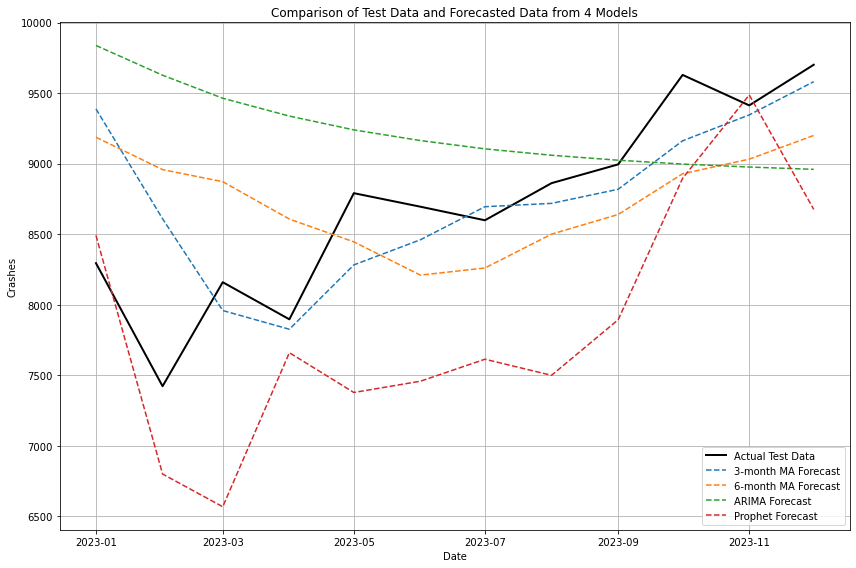

In [34]:
test_ma3 = df.loc['2023':'2024'][['3_month_MA']]
test_ma6 = df.loc['2023':'2024'][['6_month_MA']]

# Plotting the Test Data and Forecasted Data from the 4 models
plt.figure(figsize=(12, 8))

# Plot the actual test data
plt.plot(test_data, label='Actual Test Data', color='black', linewidth=2)

# Plot the 3-month Moving Average forecast
plt.plot(test_ma3, label='3-month MA Forecast', linestyle='--')

# Plot the 6-month Moving Average forecast
plt.plot(test_ma6, label='6-month MA Forecast', linestyle='--')

# Plot the ARIMA forecast
plt.plot(forecast_arima, label='ARIMA Forecast', linestyle='--')

# Plot the Prophet forecast
plt.plot(np.array(test_data.index), forecast_prophet['yhat'][-len(test_data):].values, label='Prophet Forecast', linestyle='--')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Crashes')
plt.title('Comparison of Test Data and Forecasted Data from 4 Models')
plt.legend(loc='best')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
mse_ma3 = mean_squared_error(test_data, test_ma3)
mse_ma6 = mean_squared_error(test_data, test_ma6)

print(f"Mean Squared Error (MSE) comparison:")
print(f"3-month MA: {mse_ma3}")
print(f"6-month MA: {mse_ma6}")
print(f"ARIMA: {mse_arima}")
print(f"Prophet: {mse_prophet}")

Mean Squared Error (MSE) comparison:
3-month MA: 271523.75925925944
6-month MA: 481334.7384259263
ARIMA: 1072211.4808437075
Prophet: 1013766.0431832272
